In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D
from keras import optimizers
from keras.models import Model

import tensorflow as tf
import keras.backend as K
K.set_image_data_format('channels_last')

%matplotlib inline

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
# TensorFlow wizardry
config = tf.ConfigProto() 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.5 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9209944661255007636
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2657484800
locality {
  bus_id: 1
}
incarnation: 1969504946437493307
physical_device_desc: "device: 0, name: GeForce GTX 780, pci bus id: 0000:03:00.0, compute capability: 3.5"
]


In [3]:
path = "/mnt/ML-drive/scanner-ml/Artem/share/Valerio/"
class_names = ['C100keV','TestSample']
n_pols = 8

In [4]:
def load_images(path, name_dir='TestSample', n_pols=8):
    
    img_ind = []
    path = path+name_dir+"/crops/"
    img_names = os.listdir(path)
    for name in img_names:
        img_ind.append(re.split('[_.]',name))
    img_ind = pd.DataFrame(np.array(img_ind),columns=['ViewID','gr','GrainID','pol','Polarization','cl','ClusterID','csv'])
    img_ind = img_ind.drop(['csv'],axis=1).sort_values(['ViewID','GrainID','Polarization'])
    for view in np.unique(img_ind['ViewID']):
        view_imgs = img_ind[ img_ind['ViewID']==view ]
        for grain in np.unique(view_imgs['GrainID']):
            grain_imgs = view_imgs[ view_imgs['GrainID']==grain ]
            if grain_imgs.shape[0]!=8:
                img_ind = img_ind.drop(grain_imgs.index)
    img_names = []
    for name in img_ind.values:
        img_names.append('_'.join(name)+'.csv')
    
    i=0
    im_array = []
    for name in img_names:
        if i==0 : tmp_im = []
        tmp_im.append(pd.read_csv(path+name, header=None).drop(31, axis=1).values)
        i+=1
        if i==n_pols:
            im_array.append(np.array(tmp_im).T)
            i=0
    return np.array(im_array)

In [5]:
%%time
X_sign = load_images(path, 'C100keV')
y_sign = np.ones((X_sign.shape[0],1))
X_noise = load_images(path, 'TestSample')
y_noise = np.zeros((X_noise.shape[0],1))

X = np.vstack((X_sign, X_noise))
y = np.vstack((y_sign, y_noise))

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15, stratify=y)

# Normalize image vectors (????)
#X_train = X_train_orig/255.
#X_test = X_test_orig/255.

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 19703
number of test examples = 3478
X_train shape: (19703, 31, 31, 8)
Y_train shape: (19703, 1)
X_test shape: (3478, 31, 31, 8)
Y_test shape: (3478, 1)
CPU times: user 8min 38s, sys: 6.54 s, total: 8min 45s
Wall time: 8min 39s


# Simplified CNN model

In [6]:
def CNN_model(input_shape=(31,31,8), classes=2):
    
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((1,1))(X_input)
    X = Conv2D(64, 3, name='conv1')(X)
    #X = BatchNormalization(name='batch1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(name='pool1')(X)
    print('conv1\t',X.get_shape())
    
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    if classes != 2 : print('oh no, too many classes, change the model output to softmax!')
    
    model = Model(inputs = X_input, outputs = X, name='CNN_model')
    return model

In [21]:
cnn_model = CNN_model(input_shape=(31,31,8))

conv1	 (?, 15, 15, 64)


In [22]:
nadamka = keras.optimizers.Nadam(lr=1e-5)
cnn_model.compile(optimizer=nadamka, loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
hist = cnn_model.fit(X_train, Y_train, epochs = 400, batch_size = 256, validation_split=0.15)

Train on 16747 samples, validate on 2956 samples
Epoch 1/400
16747/16747 [==============================] - 3s 151us/step - loss: 0.8577 - acc: 0.5925 - val_loss: 0.6999 - val_acc: 0.6394
Epoch 2/400
16747/16747 [==============================] - 2s 138us/step - loss: 0.7036 - acc: 0.6400 - val_loss: 0.6760 - val_acc: 0.6499
Epoch 3/400
16747/16747 [==============================] - 2s 138us/step - loss: 0.6781 - acc: 0.6524 - val_loss: 0.6532 - val_acc: 0.6482
Epoch 4/400
16747/16747 [==============================] - 2s 138us/step - loss: 0.6498 - acc: 0.6638 - val_loss: 0.6321 - val_acc: 0.6472
Epoch 5/400
16747/16747 [==============================] - 2s 137us/step - loss: 0.6255 - acc: 0.6721 - val_loss: 0.6008 - val_acc: 0.6857
Epoch 6/400
16747/16747 [==============================] - 2s 138us/step - loss: 0.6068 - acc: 0.6799 - val_loss: 0.6170 - val_acc: 0.6597
Epoch 7/400
16747/16747 [==============================] - 2s 138us/step - loss: 0.5924 - acc: 0.6838 - val_loss: 0.5

16747/16747 [==============================] - 5s 328us/step - loss: 0.4038 - acc: 0.8491 - val_loss: 0.4257 - val_acc: 0.7679
Epoch 60/400
16747/16747 [==============================] - 6s 336us/step - loss: 0.4015 - acc: 0.8489 - val_loss: 0.4002 - val_acc: 0.8627
Epoch 61/400
16747/16747 [==============================] - 5s 327us/step - loss: 0.3986 - acc: 0.8526 - val_loss: 0.3990 - val_acc: 0.8708
Epoch 62/400
16747/16747 [==============================] - 6s 333us/step - loss: 0.3983 - acc: 0.8524 - val_loss: 0.3969 - val_acc: 0.8512
Epoch 63/400
16747/16747 [==============================] - 5s 325us/step - loss: 0.3947 - acc: 0.8570 - val_loss: 0.3959 - val_acc: 0.8742
Epoch 64/400
16747/16747 [==============================] - 6s 335us/step - loss: 0.3927 - acc: 0.8582 - val_loss: 0.3931 - val_acc: 0.8643
Epoch 65/400
16747/16747 [==============================] - 5s 327us/step - loss: 0.3911 - acc: 0.8595 - val_loss: 0.4191 - val_acc: 0.8505
Epoch 66/400
16747/16747 [=======

16747/16747 [==============================] - 5s 328us/step - loss: 0.3058 - acc: 0.9036 - val_loss: 0.3134 - val_acc: 0.9012
Epoch 118/400
16747/16747 [==============================] - 5s 309us/step - loss: 0.3056 - acc: 0.9001 - val_loss: 0.3123 - val_acc: 0.9012
Epoch 119/400
16747/16747 [==============================] - 5s 310us/step - loss: 0.3036 - acc: 0.9027 - val_loss: 0.3120 - val_acc: 0.8958
Epoch 120/400
16747/16747 [==============================] - 5s 310us/step - loss: 0.3025 - acc: 0.9027 - val_loss: 0.3164 - val_acc: 0.9076
Epoch 121/400
16747/16747 [==============================] - 5s 310us/step - loss: 0.3016 - acc: 0.9022 - val_loss: 0.3207 - val_acc: 0.9002
Epoch 122/400
16747/16747 [==============================] - 5s 307us/step - loss: 0.3005 - acc: 0.9022 - val_loss: 0.3079 - val_acc: 0.9046
Epoch 123/400
16747/16747 [==============================] - 5s 314us/step - loss: 0.3007 - acc: 0.9025 - val_loss: 0.3094 - val_acc: 0.8917
Epoch 124/400
16747/16747 [

16747/16747 [==============================] - 5s 326us/step - loss: 0.2523 - acc: 0.9202 - val_loss: 0.2661 - val_acc: 0.9144
Epoch 176/400
16747/16747 [==============================] - 6s 335us/step - loss: 0.2528 - acc: 0.9183 - val_loss: 0.2725 - val_acc: 0.9039
Epoch 177/400
16747/16747 [==============================] - 5s 327us/step - loss: 0.2508 - acc: 0.9215 - val_loss: 0.2649 - val_acc: 0.9137
Epoch 178/400
16747/16747 [==============================] - 6s 333us/step - loss: 0.2497 - acc: 0.9212 - val_loss: 0.2675 - val_acc: 0.9097
Epoch 179/400
16747/16747 [==============================] - 5s 327us/step - loss: 0.2492 - acc: 0.9213 - val_loss: 0.2816 - val_acc: 0.9124
Epoch 180/400
16747/16747 [==============================] - 6s 335us/step - loss: 0.2483 - acc: 0.9225 - val_loss: 0.2632 - val_acc: 0.9141
Epoch 181/400
16747/16747 [==============================] - 6s 331us/step - loss: 0.2479 - acc: 0.9223 - val_loss: 0.2792 - val_acc: 0.8928
Epoch 182/400
16747/16747 [

16747/16747 [==============================] - 6s 329us/step - loss: 0.2174 - acc: 0.9326 - val_loss: 0.2384 - val_acc: 0.9239
Epoch 234/400
16747/16747 [==============================] - 6s 338us/step - loss: 0.2167 - acc: 0.9329 - val_loss: 0.2395 - val_acc: 0.9252
Epoch 235/400
16747/16747 [==============================] - 5s 326us/step - loss: 0.2167 - acc: 0.9331 - val_loss: 0.2387 - val_acc: 0.9171
Epoch 236/400
16747/16747 [==============================] - 6s 337us/step - loss: 0.2151 - acc: 0.9339 - val_loss: 0.2405 - val_acc: 0.9191
Epoch 237/400
16747/16747 [==============================] - 5s 326us/step - loss: 0.2156 - acc: 0.9340 - val_loss: 0.2378 - val_acc: 0.9242
Epoch 238/400
16747/16747 [==============================] - 6s 334us/step - loss: 0.2147 - acc: 0.9331 - val_loss: 0.2429 - val_acc: 0.9235
Epoch 239/400
16747/16747 [==============================] - 5s 327us/step - loss: 0.2152 - acc: 0.9331 - val_loss: 0.2378 - val_acc: 0.9263
Epoch 240/400
16747/16747 [

16747/16747 [==============================] - 6s 336us/step - loss: 0.1923 - acc: 0.9406 - val_loss: 0.2190 - val_acc: 0.9303
Epoch 292/400
16747/16747 [==============================] - 5s 326us/step - loss: 0.1924 - acc: 0.9395 - val_loss: 0.2275 - val_acc: 0.9205
Epoch 293/400
16747/16747 [==============================] - 6s 334us/step - loss: 0.1924 - acc: 0.9403 - val_loss: 0.2219 - val_acc: 0.9313
Epoch 294/400
16747/16747 [==============================] - 6s 332us/step - loss: 0.1912 - acc: 0.9418 - val_loss: 0.2208 - val_acc: 0.9320
Epoch 295/400
16747/16747 [==============================] - 6s 329us/step - loss: 0.1907 - acc: 0.9423 - val_loss: 0.2524 - val_acc: 0.8995
Epoch 296/400
16747/16747 [==============================] - 6s 336us/step - loss: 0.1912 - acc: 0.9417 - val_loss: 0.2193 - val_acc: 0.9337
Epoch 297/400
16747/16747 [==============================] - 6s 329us/step - loss: 0.1903 - acc: 0.9406 - val_loss: 0.2389 - val_acc: 0.9198
Epoch 298/400
16747/16747 [

16747/16747 [==============================] - 5s 308us/step - loss: 0.1762 - acc: 0.9457 - val_loss: 0.2085 - val_acc: 0.9269
Epoch 350/400
16747/16747 [==============================] - 5s 310us/step - loss: 0.1751 - acc: 0.9466 - val_loss: 0.2094 - val_acc: 0.9350
Epoch 351/400
16747/16747 [==============================] - 5s 310us/step - loss: 0.1751 - acc: 0.9470 - val_loss: 0.2052 - val_acc: 0.9317
Epoch 352/400
16747/16747 [==============================] - 5s 321us/step - loss: 0.1746 - acc: 0.9461 - val_loss: 0.2162 - val_acc: 0.9229
Epoch 353/400
16747/16747 [==============================] - 6s 329us/step - loss: 0.1748 - acc: 0.9466 - val_loss: 0.2046 - val_acc: 0.9350
Epoch 354/400
16747/16747 [==============================] - 6s 333us/step - loss: 0.1737 - acc: 0.9473 - val_loss: 0.2150 - val_acc: 0.9293
Epoch 355/400
16747/16747 [==============================] - 6s 337us/step - loss: 0.1741 - acc: 0.9465 - val_loss: 0.2051 - val_acc: 0.9317
Epoch 356/400
16747/16747 [

In [24]:
preds = cnn_model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3478/3478 [==============================] - 0s 120us/step
Loss = 0.19449515956067848
Test Accuracy = 0.9309948246803964


/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  """
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


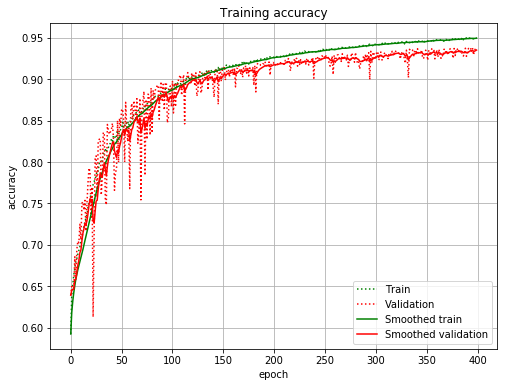

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


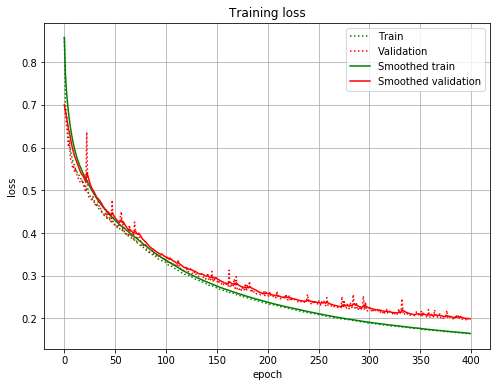

In [26]:
plt.figure(figsize=(8,6))
plt.title('Training accuracy')
plt.plot(hist.history['acc'], "g:", label='Train')
plt.plot(hist.history['val_acc'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(hist.history['acc']),span=10), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(hist.history['val_acc']),span=10), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.savefig('acc-simpl.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.title('Training loss')
plt.plot(hist.history['loss'], "g:", label='Train')
plt.plot(hist.history['val_loss'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(hist.history['loss']),span=10), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(hist.history['val_loss']),span=10), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.savefig('loss-simpl.pdf')
plt.show()

# Simplified CNN model with BatchNorm

In [103]:
def CNN_b_model(input_shape=(31,31,8), classes=2):
    
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((1,1))(X_input)
    X = Conv2D(64, 3, name='conv1')(X)
    X = BatchNormalization(name='batch1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(name='pool1')(X)
    print('conv1\t',X.get_shape())
    
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    if classes != 2 : print('oh no, too many classes, change the model output to softmax!')
    
    model = Model(inputs = X_input, outputs = X, name='CNN_model')
    return model

In [104]:
cnn_b_model = CNN_b_model(input_shape=(31,31,8))

conv1	 (?, 15, 15, 64)


In [105]:
cnn_b_model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

In [106]:
cnn_b_model.fit(X_train, Y_train, epochs = 30, batch_size = 256, validation_split=0.15)

Train on 16747 samples, validate on 2956 samples
Epoch 1/30
16747/16747 [==============================] - 4s 240us/step - loss: 0.4604 - acc: 0.8897 - val_loss: 4.8432 - val_acc: 0.6962
Epoch 2/30
16747/16747 [==============================] - 3s 171us/step - loss: 0.1812 - acc: 0.9509 - val_loss: 1.7429 - val_acc: 0.6942
Epoch 3/30
16747/16747 [==============================] - 3s 171us/step - loss: 0.1808 - acc: 0.9516 - val_loss: 0.2896 - val_acc: 0.8934
Epoch 4/30
16747/16747 [==============================] - 3s 172us/step - loss: 0.1216 - acc: 0.9697 - val_loss: 0.6243 - val_acc: 0.7087
Epoch 5/30
16747/16747 [==============================] - 3s 172us/step - loss: 0.1214 - acc: 0.9655 - val_loss: 3.5003 - val_acc: 0.6959
Epoch 6/30
16747/16747 [==============================] - 3s 172us/step - loss: 0.1058 - acc: 0.9707 - val_loss: 11.2081 - val_acc: 0.3041
Epoch 7/30
16747/16747 [==============================] - 3s 171us/step - loss: 0.0957 - acc: 0.9726 - val_loss: 3.2869 - 

In [107]:
preds = cnn_b_model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3478/3478 [==============================] - 1s 161us/step
Loss = 8.968715310439492
Test Accuracy = 0.3142610696659066


# Simplified 3D CNN model

In [6]:
%%time

X_ddd_train = np.array([X_train.T]).T
X_ddd_test = np.array([X_test.T]).T

print ("X_3d_train shape: " + str(X_ddd_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_3d_test shape: " + str(X_ddd_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

X_3d_train shape: (19703, 31, 31, 8, 1)
Y_train shape: (19703, 1)
X_3d_test shape: (3478, 31, 31, 8, 1)
Y_test shape: (3478, 1)
CPU times: user 2.78 s, sys: 380 ms, total: 3.16 s
Wall time: 3.12 s


In [7]:
def DDD_model(input_shape=(31,31,8,1), classes=2):
    
    
    X_input = Input(input_shape)
    
    X = ZeroPadding3D()(X_input)
    X = Conv3D(64, 3, name='conv1')(X)
    #X = BatchNormalization(name='batch1')(X)
    X = Activation('relu')(X)
    X = MaxPooling3D(name='pool1')(X)
    print('conv1\t',X.get_shape())
    
    #X = Conv3D(128, 3, name='conv2')(X)
    #X = BatchNormalization(name='batch2')(X)
    #X = Activation('relu')(X)
    #X = MaxPooling3D(name='pool2')(X)
    #print('conv2\t',X.get_shape())
    
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    if classes != 2 : print('oh no, too many classes, change the model output to softmax!')
    
    model = Model(inputs = X_input, outputs = X, name='3D_CNN_model')
    return model

In [15]:
ddd_model = DDD_model(input_shape=(31,31,8,1))

conv1	 (?, 15, 15, 4, 64)


In [16]:
nadamka = keras.optimizers.Nadam(lr=1e-5)
ddd_model.compile(optimizer=nadamka, loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
hist_DDD = ddd_model.fit(X_ddd_train, Y_train, epochs = 300, batch_size = 128, validation_split=0.15)

Train on 16747 samples, validate on 2956 samples
Epoch 1/300
16747/16747 [==============================] - 12s 692us/step - loss: 0.6326 - acc: 0.6750 - val_loss: 0.5823 - val_acc: 0.6945
Epoch 2/300
16747/16747 [==============================] - 12s 689us/step - loss: 0.5871 - acc: 0.6921 - val_loss: 0.5914 - val_acc: 0.6945
Epoch 3/300
16747/16747 [==============================] - 11s 686us/step - loss: 0.5772 - acc: 0.6977 - val_loss: 0.5714 - val_acc: 0.6945
Epoch 4/300
16747/16747 [==============================] - 12s 687us/step - loss: 0.5709 - acc: 0.7066 - val_loss: 0.5625 - val_acc: 0.7456
Epoch 5/300
16747/16747 [==============================] - 12s 688us/step - loss: 0.5625 - acc: 0.7131 - val_loss: 0.5593 - val_acc: 0.6945
Epoch 6/300
16747/16747 [==============================] - 12s 692us/step - loss: 0.5550 - acc: 0.7208 - val_loss: 0.5454 - val_acc: 0.6979
Epoch 7/300
16747/16747 [==============================] - 12s 690us/step - loss: 0.5462 - acc: 0.7265 - val_lo

Epoch 59/300
16747/16747 [==============================] - 11s 675us/step - loss: 0.3662 - acc: 0.8753 - val_loss: 0.3729 - val_acc: 0.8819
Epoch 60/300
16747/16747 [==============================] - 11s 676us/step - loss: 0.3615 - acc: 0.8800 - val_loss: 0.3661 - val_acc: 0.8857
Epoch 61/300
16747/16747 [==============================] - 11s 678us/step - loss: 0.3602 - acc: 0.8785 - val_loss: 0.3711 - val_acc: 0.8813
Epoch 62/300
16747/16747 [==============================] - 11s 675us/step - loss: 0.3585 - acc: 0.8817 - val_loss: 0.3645 - val_acc: 0.8589
Epoch 63/300
16747/16747 [==============================] - 11s 675us/step - loss: 0.3557 - acc: 0.8810 - val_loss: 0.3735 - val_acc: 0.8281
Epoch 64/300
16747/16747 [==============================] - 11s 678us/step - loss: 0.3556 - acc: 0.8771 - val_loss: 0.3699 - val_acc: 0.8329
Epoch 65/300
16747/16747 [==============================] - 11s 677us/step - loss: 0.3498 - acc: 0.8858 - val_loss: 0.3566 - val_acc: 0.8914
Epoch 66/300


Epoch 117/300
16747/16747 [==============================] - 11s 679us/step - loss: 0.2616 - acc: 0.9194 - val_loss: 0.2754 - val_acc: 0.9144
Epoch 118/300
16747/16747 [==============================] - 11s 674us/step - loss: 0.2623 - acc: 0.9159 - val_loss: 0.2769 - val_acc: 0.9137
Epoch 119/300
16747/16747 [==============================] - 11s 677us/step - loss: 0.2609 - acc: 0.9192 - val_loss: 0.2786 - val_acc: 0.9076
Epoch 120/300
16747/16747 [==============================] - 11s 677us/step - loss: 0.2591 - acc: 0.9192 - val_loss: 0.2687 - val_acc: 0.9100
Epoch 121/300
16747/16747 [==============================] - 11s 676us/step - loss: 0.2595 - acc: 0.9174 - val_loss: 0.2739 - val_acc: 0.9154
Epoch 122/300
16747/16747 [==============================] - 11s 678us/step - loss: 0.2556 - acc: 0.9211 - val_loss: 0.2664 - val_acc: 0.9151
Epoch 123/300
16747/16747 [==============================] - 11s 678us/step - loss: 0.2572 - acc: 0.9181 - val_loss: 0.2648 - val_acc: 0.9134
Epoch 

Epoch 175/300
16747/16747 [==============================] - 11s 676us/step - loss: 0.2107 - acc: 0.9343 - val_loss: 0.2310 - val_acc: 0.9263
Epoch 176/300
16747/16747 [==============================] - 11s 680us/step - loss: 0.2118 - acc: 0.9349 - val_loss: 0.2283 - val_acc: 0.9256
Epoch 177/300
16747/16747 [==============================] - 11s 675us/step - loss: 0.2134 - acc: 0.9298 - val_loss: 0.2243 - val_acc: 0.9229
Epoch 178/300
16747/16747 [==============================] - 11s 675us/step - loss: 0.2093 - acc: 0.9349 - val_loss: 0.2699 - val_acc: 0.8958
Epoch 179/300
16747/16747 [==============================] - 11s 677us/step - loss: 0.2096 - acc: 0.9344 - val_loss: 0.2234 - val_acc: 0.9225
Epoch 180/300
16747/16747 [==============================] - 11s 677us/step - loss: 0.2096 - acc: 0.9352 - val_loss: 0.2232 - val_acc: 0.9279
Epoch 181/300
16747/16747 [==============================] - 11s 675us/step - loss: 0.2082 - acc: 0.9356 - val_loss: 0.2282 - val_acc: 0.9154
Epoch 

Epoch 233/300
16747/16747 [==============================] - 11s 680us/step - loss: 0.1853 - acc: 0.9420 - val_loss: 0.2024 - val_acc: 0.9337
Epoch 234/300
16747/16747 [==============================] - 11s 678us/step - loss: 0.1842 - acc: 0.9429 - val_loss: 0.2000 - val_acc: 0.9320
Epoch 235/300
16747/16747 [==============================] - 11s 678us/step - loss: 0.1841 - acc: 0.9414 - val_loss: 0.2070 - val_acc: 0.9337
Epoch 236/300
16747/16747 [==============================] - 11s 677us/step - loss: 0.1828 - acc: 0.9420 - val_loss: 0.2010 - val_acc: 0.9350
Epoch 237/300
16747/16747 [==============================] - 11s 679us/step - loss: 0.1829 - acc: 0.9421 - val_loss: 0.2071 - val_acc: 0.9252
Epoch 238/300
16747/16747 [==============================] - 11s 677us/step - loss: 0.1831 - acc: 0.9419 - val_loss: 0.2131 - val_acc: 0.9290
Epoch 239/300
16747/16747 [==============================] - 11s 675us/step - loss: 0.1832 - acc: 0.9409 - val_loss: 0.2343 - val_acc: 0.9158
Epoch 

Epoch 291/300
16747/16747 [==============================] - 11s 677us/step - loss: 0.1648 - acc: 0.9497 - val_loss: 0.1836 - val_acc: 0.9401
Epoch 292/300
16747/16747 [==============================] - 11s 680us/step - loss: 0.1631 - acc: 0.9492 - val_loss: 0.1833 - val_acc: 0.9394
Epoch 293/300
16747/16747 [==============================] - 11s 679us/step - loss: 0.1643 - acc: 0.9495 - val_loss: 0.1862 - val_acc: 0.9367
Epoch 294/300
16747/16747 [==============================] - 11s 678us/step - loss: 0.1664 - acc: 0.9495 - val_loss: 0.1937 - val_acc: 0.9293
Epoch 295/300
16747/16747 [==============================] - 11s 677us/step - loss: 0.1641 - acc: 0.9507 - val_loss: 0.2015 - val_acc: 0.9205
Epoch 296/300
16747/16747 [==============================] - 11s 678us/step - loss: 0.1640 - acc: 0.9496 - val_loss: 0.2040 - val_acc: 0.9313
Epoch 297/300
16747/16747 [==============================] - 11s 683us/step - loss: 0.1653 - acc: 0.9486 - val_loss: 0.1880 - val_acc: 0.9320
Epoch 

In [18]:
preds = ddd_model.evaluate(X_ddd_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3478/3478 [==============================] - 2s 441us/step
Loss = 0.20284263908760242
Test Accuracy = 0.934445083449804


/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  """
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


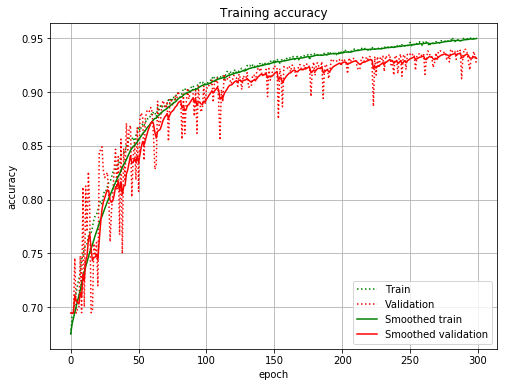

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


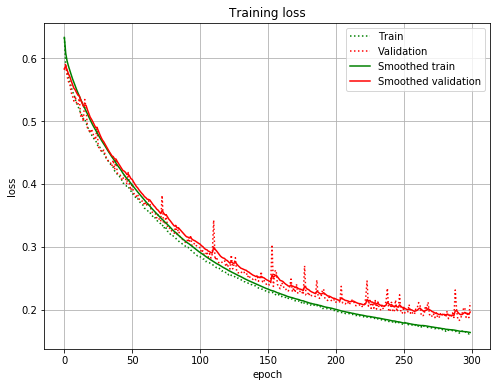

In [19]:
plt.figure(figsize=(8,6))
plt.title('Training accuracy')
plt.plot(hist_DDD.history['acc'], "g:", label='Train')
plt.plot(hist_DDD.history['val_acc'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(hist_DDD.history['acc']),span=10), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(hist_DDD.history['val_acc']),span=10), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.savefig('acc-simpl3D.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.title('Training loss')
plt.plot(hist_DDD.history['loss'], "g:", label='Train')
plt.plot(hist_DDD.history['val_loss'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(hist_DDD.history['loss']),span=10), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(hist_DDD.history['val_loss']),span=10), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.savefig('loss-simpl3D.pdf')
plt.show()